In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, accuracy_score
    )
from sklearn.ensemble import ExtraTreesClassifier
from category_encoders.binary import BinaryEncoder
%matplotlib inline

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Synthetic Fraud data

### Load data

In [4]:
fraud_data = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

## Prepare data  

So, due to the Boruta results, we'll just leave out the name columns and encode the type in binary form and see what happens.  
Also, for cleanliness, I'll start dropping the isFlaggedFraud column.

In [5]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
categorical_dict = {'type': {'CASH_OUT' : 0, 'TRANSFER' : 1, 'DEBIT' : 2, 'CASH_IN' : 3, 'PAYMENT' : 4}}
fraud_data.replace(categorical_dict, inplace=True)

In [7]:
benc = BinaryEncoder(cols=['type'])
fraud_data = benc.fit_transform(fraud_data)

In [8]:
fraud_data.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [9]:
fraud_data.head()

,step,type_0,type_1,type_2,type_3,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,0,0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,0,0,0,1,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,0,0,1,0,181.00,181.0,0.00,0.0,0.0,1
3,1,0,0,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,0,0,0,1,11668.14,41554.0,29885.86,0.0,0.0,0


In [10]:
fraud_data.columns

Index(['step', 'type_0', 'type_1', 'type_2', 'type_3', 'amount',
       'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
       'isFraud'],
      dtype='object')

In [11]:
train_cols = ['type_0', 'type_1', 'type_2', 'type_3', 'amount',
       'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
label_col = ['isFraud']

In [12]:
train_length = np.round(len(fraud_data.index) * 0.9, 0)
train_X = fraud_data.loc[:train_length, train_cols]
train_y = fraud_data.loc[:train_length, label_col]
valid_X = fraud_data.loc[train_length:, train_cols]
valid_y = fraud_data.loc[train_length:, label_col]

Let's see how many fraud cases we've got in our training set.

In [13]:
train_y.sum()

isFraud    4449
dtype: int64

Huh. This is tough. The majority of cases are in the latter half of the dataset - if you want to train it realistically, you have to take its timeline into account. So this way, the model won't have seen even half of the cases it will eventually be exposed to.

## Run simple model (LightGBM)

In [14]:
import lightgbm as lgbm

In [15]:
clf = lgbm.LGBMClassifier(n_estimators=1000, random_state=42, class_weight='balanced', objective='binary')

clf.fit(train_X, np.ravel(train_y))

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

Precision:  0.4119632258815315
Recall:  0.9404888416578109
ROC score:  0.9662499417949796
F1 score:  0.5729546006312213
Accuracy score:  0.9917062467977028


So just by playing with the numbers in the default settings, if we increase the training dataset from 70% to 90% we expose the model to about half the examples in the dataset. This increases the precision from 0.03 to 0.30, which is much better. Still, it's not exactly amazing.  
Also, we haven't played with any of the models hyperparameters *AT ALL*. Of course we could do that.  
Let's see what else we can do.  
Okay, so just a really dumb test - increase the number of estimators by a factor of 10 to 1000 and we get a precision of 92% and recall of about 47%. NOT BAD for a simple move.  
I'm going to predict that if we set the class weights to 'balanced', that precision will go down and the recall will go up. Let's check that.  
Fascinating - yes, that's exactly what happened. However, we're nowhere near at the optimisation of the lgbm model for classification like this.
We've seen that there were only a few thousand account numbers that repeated, so gathering historical data on the activities of an account does not seem to be useful. A different model could be useful - we could try the most successful model from the imbalanced dataset examples and see if that performs better here as well.
A combination of ExtraTrees with HellingerDistanceCriterion might be very interesting.

As for engineered features, this is a tough one. It might help to first look at feature importances or coefficients in the model before something like differences between origin and destination or anything come into play.

In [16]:
clf.feature_importances_

array([   0,    6,  135,  686, 9012, 8256,  705, 5283, 5917], dtype=int32)

In [17]:
def get_lgbm_varimp(model, train_columns, max_vars=50):
    cv_varimp_df = pd.DataFrame([train_columns, model.feature_importances_]).T
    cv_varimp_df.columns = ['feature_name', 'varimp']
    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)    
    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]
    return cv_varimp_df

def plotImp(model, X, num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
#    plt.savefig('lgbm_importances-01.png')
    plt.show()

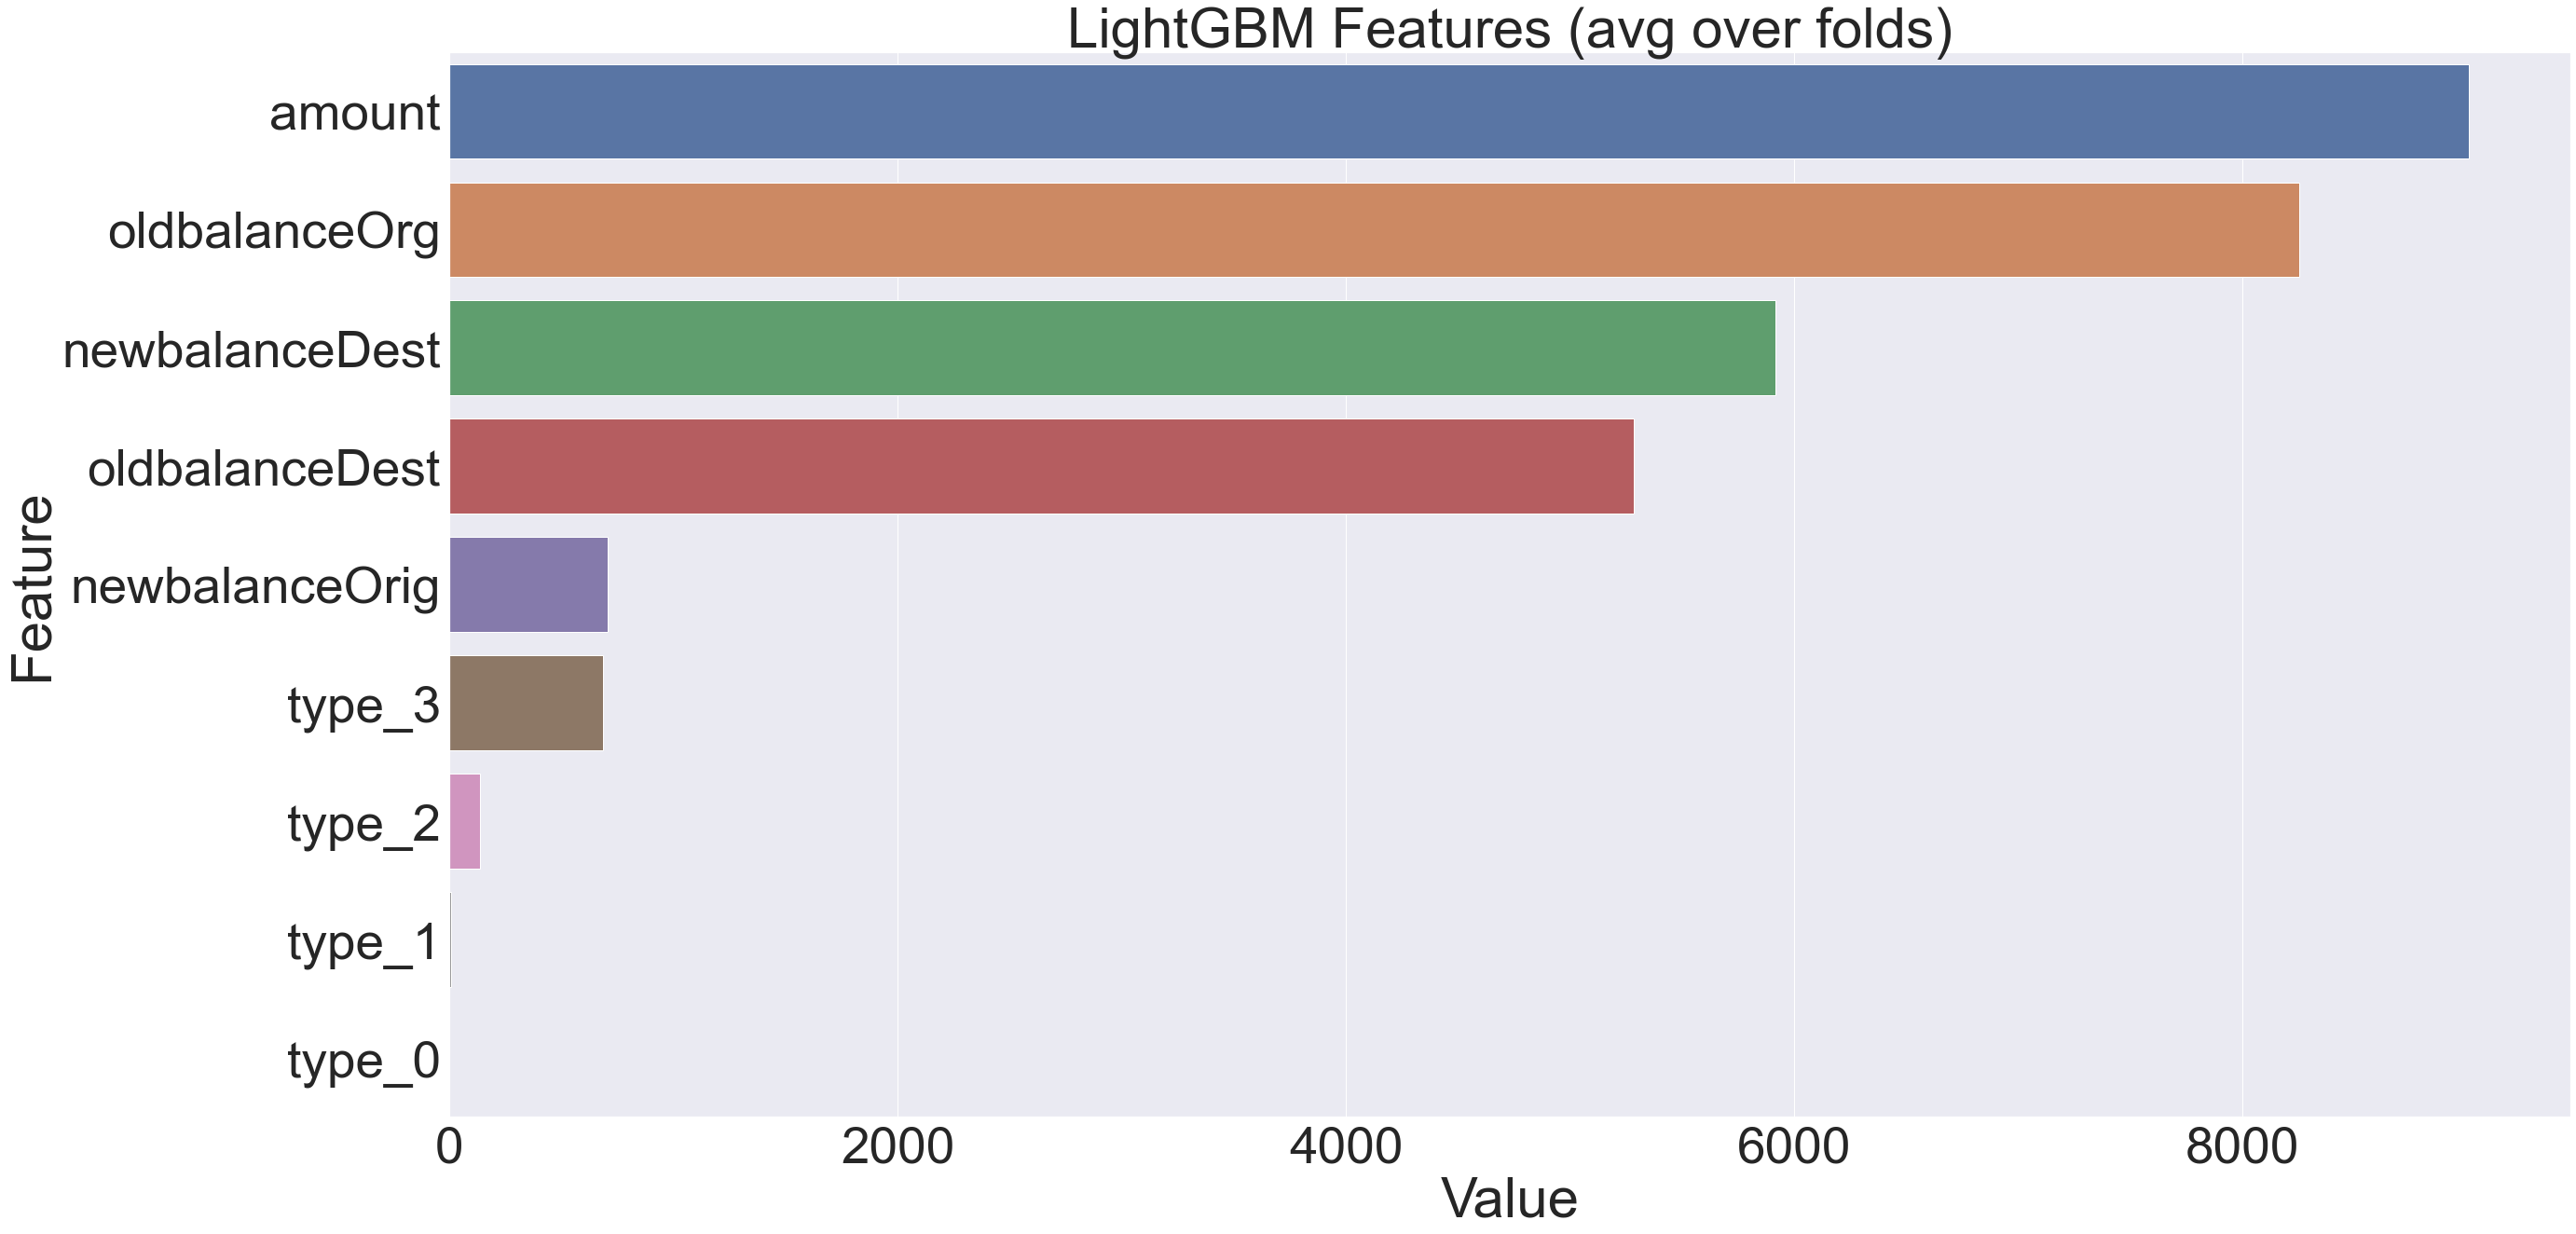

In [18]:
plotImp(clf, train_cols)

Hm, this is a bit odd - one would think that the most important feature to begin with is the type, since there are only two types that contain frauds. But then again, maybe that makes it less important? But wouldn't that cut the problem in half already? Hm. This is not really clear to me.

In [19]:
clf = ExtraTreesClassifier(n_estimators=250, random_state=42, class_weight='balanced')

clf.fit(train_X, np.ravel(train_y))

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

Precision:  0.993550577053632
Recall:  0.7776301806588736
ROC score:  0.8888000705190974
F1 score:  0.8724292101341282
Accuracy score:  0.9986546422700082


Uhm. That is a lot cooler than I expected. Uhm. Alright. Now I DEFINITELY want to try the Hellinger distance.  
Anyway, so for fine tuning, we should bring the number of estimators down and introduce a max_depth term to optimise model size.

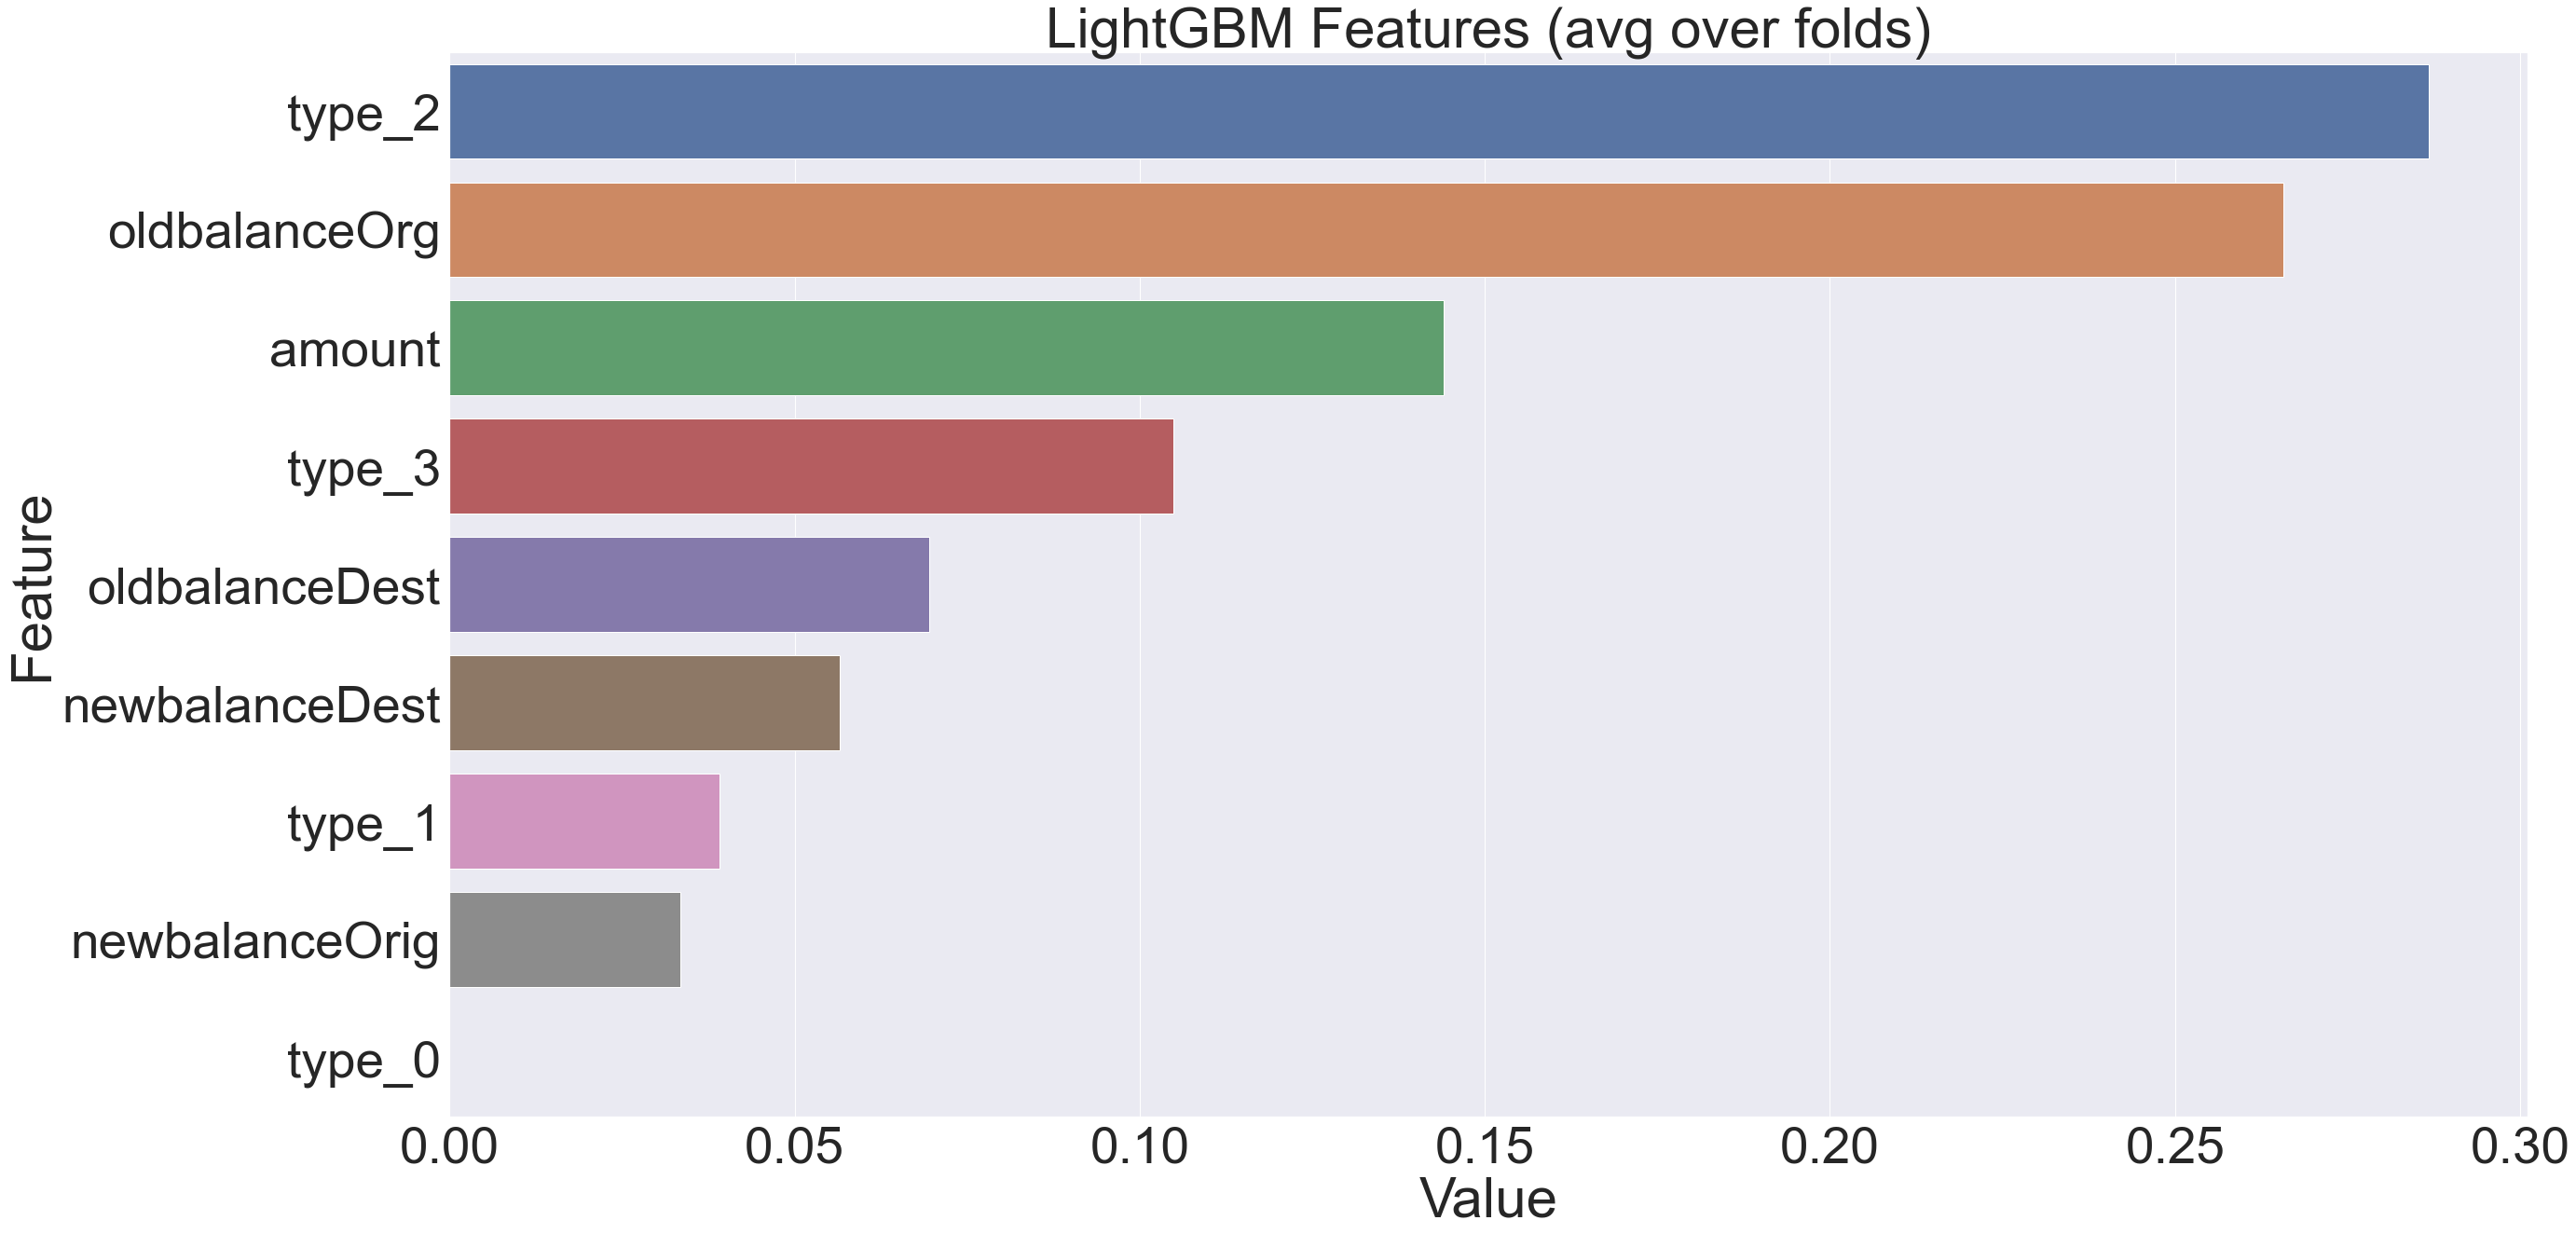

In [20]:
plotImp(clf, train_cols)

In [21]:
from hellinger_distance_criterion import HellingerDistanceCriterion
hdc = HellingerDistanceCriterion(1, np.array([2],dtype='int64'))

clf = ExtraTreesClassifier(criterion=hdc, n_estimators=250, random_state=42, class_weight='balanced')


clf.fit(train_X, np.ravel(train_y))

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

Precision:  0.9942760942760943
Recall:  0.7845377258235919
ROC score:  0.892255424134124
F1 score:  0.877041877041877
Accuracy score:  0.9986986492985594


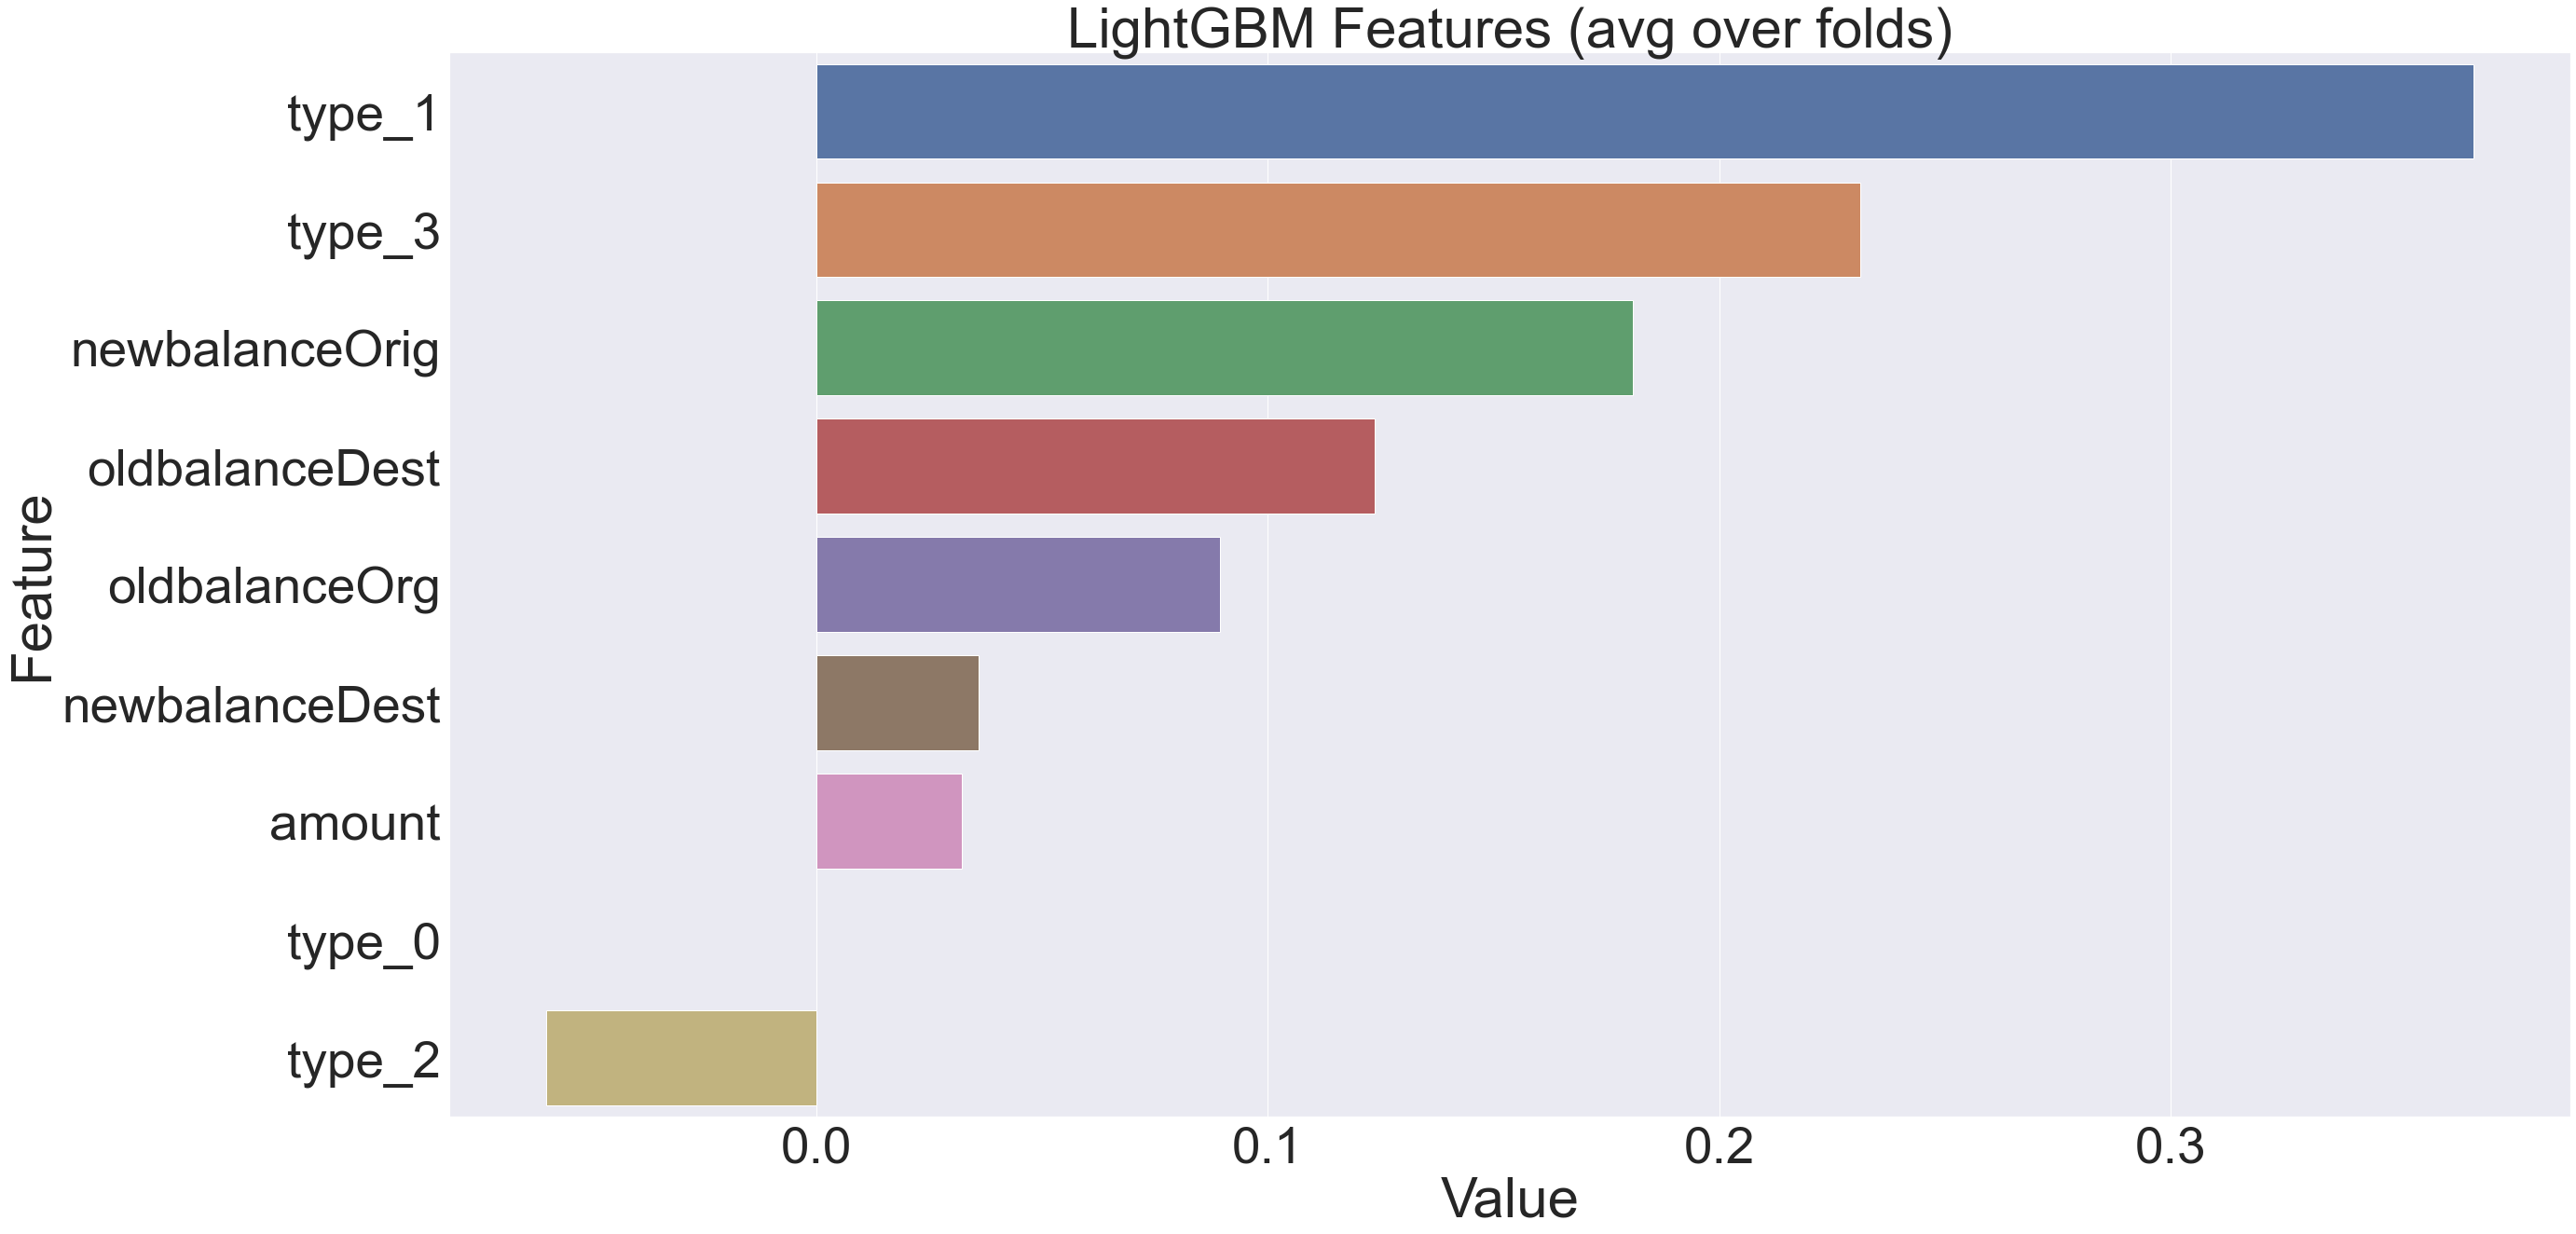

In [22]:
plotImp(clf, train_cols)

Okay, so we've got numerical encodings for our name features - which *might* be meaningless, but according to this graph are not. Now, these are not ordinal. It make make sense to give them a binary encoding instead. I'll have a look at how many columns that would be.

In [23]:
from imblearn.ensemble import BalancedRandomForestClassifier

Using TensorFlow backend.


In [24]:
hdc = HellingerDistanceCriterion(1, np.array([2],dtype='int64'))

clf = BalancedRandomForestClassifier(criterion=hdc, n_estimators=250, random_state=42, class_weight='balanced')

clf.fit(train_X, np.ravel(train_y))

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

Precision:  0.2742440801457195
Recall:  1.0
ROC score:  0.9921256668005275
F1 score:  0.4304419921093258
Accuracy score:  0.984344499592935


While we're at it, let's have a look at our friend xgboost.

In [28]:
import xgboost as xgb

In [29]:
clf = xgb.XGBClassifier(random_state=42)

clf.fit(train_X, np.ravel(train_y))

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

[15:19:43] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Precision:  0.9965647543799382
Recall:  0.7707226354941552
ROC score:  0.8853534125837411
F1 score:  0.8692134831460674
Accuracy score:  0.9986279237169594
